In [1]:
#!/usr/bin/env python3
import qiskit
from qiskit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    transpile
)
from qiskit.quantum_info import (
    Kraus, 
    SuperOp,
)
from qiskit_aer.noise import(
    depolarizing_error,
    phase_damping_error,
    NoiseModel,
    QuantumError,
    amplitude_damping_error,
)
# from qiskit_ibm_provider import IBMProvider
from qiskit import Aer
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import math
import sys
sys.path.append('../')
import utilities as utl
import importlib
import json
importlib.reload(utl)
# BASIS=["h", "x", "rz", "ccx", "cx", "cz", "id"]

SHOTS=100000
def _graph_pcsZ(qc, qreg):
    print(qreg.size)
    for idx in list(range(qreg.size)):
        if idx != 1:
            qc.h(qreg[idx])
    # root left pcs
    qc.cx(qreg[0],qreg[1])
    qc.cz(qreg[5],qreg[1])
    qc.cx(qreg[4],qreg[1])
    qc.cz(qreg[3],qreg[0])
    qc.cx(qreg[2],qreg[0])
    qc.barrier()
    qc.id([qreg[0], qreg[1],qreg[2],qreg[3],qreg[4],qreg[5]])
    qc.barrier()
    qc.cx(qreg[2],qreg[0])
    qc.cz(qreg[3],qreg[0])
    qc.cx(qreg[4],qreg[1])
    qc.cz(qreg[5],qreg[1])
    qc.barrier() 
    qc.h([qreg[2], qreg[3], qreg[4],qreg[5]])

    return qc 

In [2]:
tot_pcs_ancillas=4
a_qreg=QuantumRegister(6, "a")
pcs_creg=ClassicalRegister(4,"pcs")
bsm_creg=ClassicalRegister(2, "bsm")
epr_creg=ClassicalRegister(2, "epr")
junk_creg=ClassicalRegister(8, "junk") #for removing and connecting nodes
qc=QuantumCircuit(a_qreg, epr_creg, bsm_creg, pcs_creg, junk_creg)
qc=_graph_pcsZ(qc, a_qreg)

# PCS measurements.
qc.barrier()
qc.measure(a_qreg[2], pcs_creg[0])
qc.measure(a_qreg[3], pcs_creg[1])
qc.measure(a_qreg[4], pcs_creg[2])
qc.measure(a_qreg[5], pcs_creg[3])

# Convert 2 qubit graph states to bell States. These cancel with h gate from the X-basis graph measeurements.
# qc.h(a_qreg[0])
# qc.h(b_qreg[0])

qc.barrier()
print(qc)

6
        ┌───┐                ┌───┐ ░ ┌───┐ ░ ┌───┐            ░       ░       »
   a_0: ┤ H ├──■──────■──────┤ X ├─░─┤ I ├─░─┤ X ├──────■─────░───────░───────»
        └───┘┌─┴─┐    │ ┌───┐└─┬─┘ ░ ├───┤ ░ └─┬─┘┌───┐ │     ░       ░       »
   a_1: ─────┤ X ├─■──┼─┤ X ├──┼───░─┤ I ├─░───┼──┤ X ├─┼──■──░───────░───────»
        ┌───┐└───┘ │  │ └─┬─┘  │   ░ ├───┤ ░   │  └─┬─┘ │  │  ░ ┌───┐ ░ ┌─┐   »
   a_2: ┤ H ├──────┼──┼───┼────■───░─┤ I ├─░───■────┼───┼──┼──░─┤ H ├─░─┤M├───»
        ├───┤      │  │   │        ░ ├───┤ ░        │   │  │  ░ ├───┤ ░ └╥┘┌─┐»
   a_3: ┤ H ├──────┼──■───┼────────░─┤ I ├─░────────┼───■──┼──░─┤ H ├─░──╫─┤M├»
        ├───┤      │      │        ░ ├───┤ ░        │      │  ░ ├───┤ ░  ║ └╥┘»
   a_4: ┤ H ├──────┼──────■────────░─┤ I ├─░────────■──────┼──░─┤ H ├─░──╫──╫─»
        ├───┤      │               ░ ├───┤ ░               │  ░ ├───┤ ░  ║  ║ »
   a_5: ┤ H ├──────■───────────────░─┤ I ├─░───────────────■──░─┤ H ├─░──╫──╫─»
        └───┘                      ░ └

In [3]:
pcs_all_fidelities=[]
pcs_post_select_rates=[]
errors=np.linspace(0.0, stop=0.5, num=11, endpoint=True)
error_gate1=0.001
# error_gate1=0
# errors=[0]
for error in errors:
        noise_model=utl.get_noise_model(error_gate1)
        print(f"depolarizing error: {error}")
        depol1=depolarizing_error(error, 1)
        noise_model.add_all_qubit_quantum_error(depol1, ["id"])
        print(noise_model)

        backend=AerSimulator(noise_model=noise_model)
        pcs_ancillas_pos=1 # the position of the classical registers that contain the pcs measurements.
        result_xx=utl.meas_xx(qc, [a_qreg[0], a_qreg[1]], epr_creg, backend, SHOTS)
        result_yy=utl.meas_yy(qc, [a_qreg[0], a_qreg[1]], epr_creg, backend, SHOTS)
        result_zz=utl.meas_zz(qc, [a_qreg[0], a_qreg[1]], epr_creg, backend, SHOTS)

        xx_counts=utl.post_select(result_xx.get_counts(), tot_pcs_ancillas, pcs_ancillas_pos)
        yy_counts=utl.post_select(result_yy.get_counts(), tot_pcs_ancillas, pcs_ancillas_pos)
        zz_counts=utl.post_select(result_zz.get_counts(), tot_pcs_ancillas, pcs_ancillas_pos)
        pcs_post_select_rates.append(min([sum(xx_counts.values()),sum(yy_counts.values()),sum(zz_counts.values())])/SHOTS)
        epr_idx=-1 #the position of the classical registers that contain measurements of the 
                #epr pair.
        expect_xx=utl.expect_of_vals(utl.to_percent(utl.collect_meas(xx_counts, epr_idx)))
        expect_yy=utl.expect_of_vals(utl.to_percent(utl.collect_meas(yy_counts, epr_idx)))
        expect_zz=utl.expect_of_vals(utl.to_percent(utl.collect_meas(zz_counts, epr_idx)))
        pcs_fidelity=utl.fidelity_phip(expect_xx, expect_yy, expect_zz)
        print(pcs_fidelity)
        pcs_all_fidelities.append(pcs_fidelity)

depolarizing error: 0.0
NoiseModel:
  Basis gates: ['ccx', 'cx', 'cz', 'h', 'id', 'rz', 'sx', 'x', 'y', 'z']
  Instructions with noise: ['cz', 'cx', 'measure', 'ccx', 'x', 'rz', 'z', 'y', 'h']
  All-qubits errors: ['cx', 'cz', 'ccx', 'h', 'x', 'y', 'z', 'rz', 'measure']
xx circ: 
        ┌───┐                ┌───┐ ░ ┌───┐ ░ ┌───┐            ░       ░       »
   a_0: ┤ H ├──■──────■──────┤ X ├─░─┤ I ├─░─┤ X ├──────■─────░───────░───────»
        └───┘┌─┴─┐    │ ┌───┐└─┬─┘ ░ ├───┤ ░ └─┬─┘┌───┐ │     ░       ░       »
   a_1: ─────┤ X ├─■──┼─┤ X ├──┼───░─┤ I ├─░───┼──┤ X ├─┼──■──░───────░───────»
        ┌───┐└───┘ │  │ └─┬─┘  │   ░ ├───┤ ░   │  └─┬─┘ │  │  ░ ┌───┐ ░ ┌─┐   »
   a_2: ┤ H ├──────┼──┼───┼────■───░─┤ I ├─░───■────┼───┼──┼──░─┤ H ├─░─┤M├───»
        ├───┤      │  │   │        ░ ├───┤ ░        │   │  │  ░ ├───┤ ░ └╥┘┌─┐»
   a_3: ┤ H ├──────┼──■───┼────────░─┤ I ├─░────────┼───■──┼──░─┤ H ├─░──╫─┤M├»
        ├───┤      │      │        ░ ├───┤ ░        │      │  ░ ├───┤ ░  ║ └╥┘»

[0.9699935173327063, 0.9410870017625491, 0.9100876796932484, 0.8726160369149866, 0.8292116559520506, 0.7821560803953682, 0.7324542305024879, 0.678815182290561, 0.6128748221747022, 0.5590914861528803, 0.5008063198412593]
[0.94526, 0.77417, 0.6345, 0.51837, 0.42187, 0.34538, 0.28442, 0.23447, 0.19167, 0.16169, 0.13538]
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]


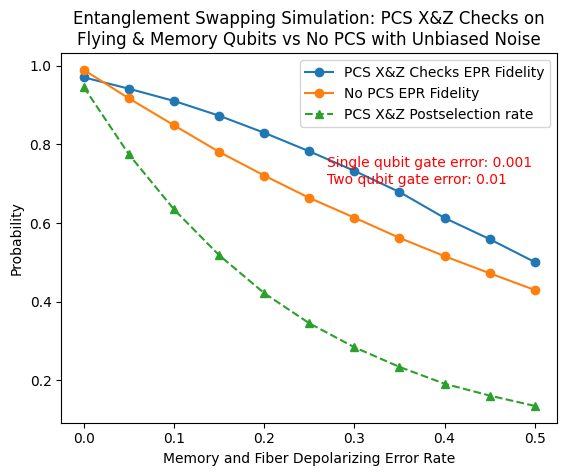

[0.9699935173327063, 0.9410870017625491, 0.9100876796932484, 0.8726160369149866, 0.8292116559520506, 0.7821560803953682, 0.7324542305024879, 0.678815182290561, 0.6128748221747022, 0.5590914861528803, 0.5008063198412593]
[0.9888499999999999, 0.9166, 0.8482000000000001, 0.7807, 0.72065, 0.66375, 0.61365, 0.56225, 0.5157499999999999, 0.47245000000000004, 0.42995]
[0.94526, 0.77417, 0.6345, 0.51837, 0.42187, 0.34538, 0.28442, 0.23447, 0.19167, 0.16169, 0.13538]
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]


In [5]:
print(pcs_all_fidelities)
print(pcs_post_select_rates)
print(errors)
reps=1
with open(f"json\\pcsXZ_rec0_unbiased_noswap.json", "w") as fxz:
        json.dump({"errors": errors.tolist(), "fidelities": pcs_all_fidelities, "postselectRates": pcs_post_select_rates}, fxz)
with open("json\\raw_unbiased_noswap.json") as fRaw:
        dataRaw=json.load(fRaw)
nopcs_all_fidelities=dataRaw["fidelities"]
plt.plot(errors, pcs_all_fidelities, label="PCS X&Z Checks EPR Fidelity", marker='o')
plt.plot(errors, nopcs_all_fidelities, label="No PCS EPR Fidelity", marker='o')
plt.plot(errors, pcs_post_select_rates, label="PCS X&Z Postselection rate",  marker='^', linestyle="--")
plt.ylabel('Probability')
plt.xlabel(f"Memory and Fiber Depolarizing Error Rate")
plt.text(0.27, .7, f"Single qubit gate error: {error_gate1}\nTwo qubit gate error: {round(error_gate1*10, 4)}", color = "red")
plt.title(f"Entanglement Swapping Simulation: PCS X&Z Checks on\nFlying & Memory Qubits vs No PCS with Unbiased Noise")
plt.legend()
plt.savefig(f"images\\pcsXZ_rec0_unbiased_noswap.png")
plt.show()
print(pcs_all_fidelities)
print(nopcs_all_fidelities)
print(pcs_post_select_rates)
print(errors)